# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import gc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import pickle
import functions.utils as utils

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Estilos default:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)
default_color = '#56B4E9'
colormap = plt.cm.cool

In [3]:
# Escolhendo os diretórios:
path = './data/raw/PeNSE_2015_AMOSTRA1/arquivos csv/'
output_path = './data/output/'

# Descrição dos dados

Serão considerados apenas os dados da **Amostra 1**: escolares matriculados e frequentando regularmente o 9º ano do Ensino Fundamental

* **PENSE_AMOSTRA1_ALUNO**: quesitos do questionário do aluno para Amostra 1.
* **PENSE_AMOSTRA1_ALUNOESCOLA**: quesitos do questionário do aluno relacionados
aos da escola para Amostra 1.
* **PENSE_AMOSTRA1_ESCOLA**: quesitos do questionário da escola para Amostra 1.

# Carregando os arquivos

Carregando os dados dos arquivos .csv.
* Separador das colunas = **;**
* Indicador de decimal = **,** (necessário por exemplo na feature '**PESO**')

In [4]:
aluno = pd.read_csv(path + 'PENSE_AMOSTRA1_ALUNO.CSV', sep=';', decimal=',')
escola = pd.read_csv(path + 'PENSE_AMOSTRA1_ESCOLA.CSV', sep=';', decimal=',')
aluno_escola = pd.read_csv(path + 'PENSE_AMOSTRA1_ALUNOESCOLA.CSV', sep=';', decimal=',')

Verificando o número de exemplos (linhas) e features (colunas):

In [5]:
print("aluno:        ",aluno.shape)
print("aluno_escola: ",aluno_escola.shape)
print("escola:       ",escola.shape)

aluno:         (102072, 174)
aluno_escola:  (102072, 293)
escola:        (102072, 131)


Pequenas amostras dos dados, para visualização:

In [6]:
aluno.head()

,ANOPESQ,PAIS,REGEOGR,UFCENSO,MUNICIPIO_CAP,TIPO_MUNIC,VB00004,VB01001,VB01002,VB01003,...,VB16001A05,VB16001A06,VB16001A07,VB16001A08,ESTRATO_EXP,ESTRATOGEOREG,PESO,aluno,escola,turma
0,2015,76,1,11,1100205,1,1,2,1,14,...,2,2,2,2,110020521,1100205,3.74,1,1,1787
1,2015,76,1,11,1100205,1,1,1,4,16,...,2,2,2,2,110020521,1100205,3.74,2,1,1787
2,2015,76,1,11,1100205,1,1,1,1,13,...,2,2,2,2,110020521,1100205,3.74,3,1,1787
3,2015,76,1,11,1100205,1,1,1,4,14,...,1,2,2,2,110020521,1100205,3.74,4,1,1787
4,2015,76,1,11,1100205,1,1,1,1,14,...,2,1,2,2,110020521,1100205,3.74,5,1,1787


In [7]:
aluno_escola.head()

,ANOPESQ,PAIS,REGEOGR,UFCENSO,MUNICIPIO_CAP,TIPO_MUNIC,VB00004,VB01001,VB01002,VB01003,...,VE01P28A,VE01P68,VE01P69,VE01P70,VE01P71,VE01P72,V0041,aluno,escola,turma
0,2015,76,1,11,1100205,1,1,2,1,14,...,1,1,1,1,1,1,1,1,1,1787
1,2015,76,1,11,1100205,1,1,1,4,16,...,1,1,1,1,1,1,1,2,1,1787
2,2015,76,1,11,1100205,1,1,1,1,13,...,1,1,1,1,1,1,1,3,1,1787
3,2015,76,1,11,1100205,1,1,1,4,14,...,1,1,1,1,1,1,1,4,1,1787
4,2015,76,1,11,1100205,1,1,1,1,14,...,1,1,1,1,1,1,1,5,1,1787


In [8]:
escola.head()

,ANOPESQ,PAIS,REGEOGR,UFCENSO,MUNICIPIO_CAP,TIPO_MUNIC,V0006,V0007,V0008,VE01P3001,...,VE01P70,VE01P71,VE01P72,V0041,ESTRATO_EXP,ESTRATOGEOREG,PESO,aluno,escola,turma
0,2015,76,1,11,1100205,1,1,2,4,1,...,1,1,1,1,110020521,1100205,3.74,1,1,1787
1,2015,76,1,11,1100205,1,1,2,4,1,...,1,1,1,1,110020521,1100205,3.74,2,1,1787
2,2015,76,1,11,1100205,1,1,2,4,1,...,1,1,1,1,110020521,1100205,3.74,3,1,1787
3,2015,76,1,11,1100205,1,1,2,4,1,...,1,1,1,1,110020521,1100205,3.74,4,1,1787
4,2015,76,1,11,1100205,1,1,2,4,1,...,1,1,1,1,110020521,1100205,3.74,5,1,1787


Como se relacionam os arquivos **aluno.csv** e **escola.csv** com o **aluno_escola.csv**?

In [9]:
count_aluno = 0
count_escola = 0
count_and = 0
for feature in aluno_escola.columns:
    if feature in aluno.columns:
        count_aluno = count_aluno + 1
    if feature in escola.columns:
        count_escola = count_escola + 1
    if feature in escola.columns and feature in aluno.columns:
        count_and = count_and + 1
#Somando dos contadores e retirando o número de features existentes nos dois arquivos
count_aluno+count_escola-count_and

293

As features existentes no arquivo **aluno_escola.csv** são as mesmas dos arquivos **aluno.csv** e **escola.csv**. Conforme podemos ver mais acima, o número de features do aluno_escola.csv é **293**.

#### Checando valores duplicados

Existem exemplos (linhas) com todas as features iguais? Isso poderia indicar exemplos duplicados.

In [10]:
utils.check_full_duplicates(aluno)

There are NOT duplicated samples


In [11]:
utils.check_full_duplicates(aluno_escola)

There are NOT duplicated samples


In [12]:
utils.check_full_duplicates(escola)

There are NOT duplicated samples


Não existem.

Existem exemplos (linhas) com o mesmo ID de aluno? Isso também poderia indicar exemplos duplicados.

In [13]:
any(aluno['aluno'].duplicated())

False

In [14]:
any(aluno_escola['aluno'].duplicated())

False

In [15]:
any(escola['aluno'].duplicated())

False

Não existem.

#### Valores faltantes (NaNs)

* NaNs = temos os casos abaixo, conforme dicionário de dados fornecido
> **PENSE_AMOSTRA1_ALUNO.CSV**
    Não informado = 99

    > **PENSE_AMOSTRA1_ESCOLA.CSV**
    Não informado = 9

    > **PENSE_AMOSTRA1_ALUNOESCOLA.CSV**
    Descobrimos mais acima que este arquivo possui os dados dos outros arquivos. Portanto temos os dois casos:
    
        > features de aluno: Não informado = 99;
        > features de escola: Não informado = 9

Devemos substituir os valores "Não informado" de acordo com cada feature em cada arquivo. Não podemos fazer via parâmetro **na_values** do pandas de **forma geral** (sempre considerar 99 e 9 como NaN) devido a features que não são NaNs. Por exemplo, ID de alunos 9 e 99.

Além disso, o caso do arquivo **PENSE_AMOSTRA1_ALUNOESCOLA.CSV** precisa de tratativa especial de NaNs. Não podemos simplesmente substituir os valores "99" e "9" por NaN, pois nas features pertencentes a **PENSE_AMOSTRA1_ALUNO.CSV** existem valores "9" informativos.

As tratativas informadas são realizadas abaixo:

In [16]:
#Arquivo
#Features que não possuem a categoria "99 = Não Informado"
aluno_features_not_nan = ['ANOPESQ', 'PAIS', 'REGEOGR', 'UFCENSO', 'MUNICIPIO_CAP', 'TIPO_MUNIC', 'VB00004', 'VB01001',
                           'VB01003', 'TEMPODESLOC', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOTOTAL', 'TEMPOEST', 'ESTRATOGEOREG',
                          'ESTRATO_EXP', 'PESO', 'aluno', 'escola', 'turma']
dict_nan_aluno = {}
for feat in aluno.columns:
    if feat not in aluno_features_not_nan:
        dict_nan_aluno[feat] = 99

#Features que não possuem a categoria "9 = Não Informado"
escola_features_not_nan = ['ANOPESQ', 'PAIS', 'REGEOGR', 'UFCENSO', 'MUNICIPIO_CAP', 'TIPO_MUNIC', 'V0006', 'V0007',
                           'V0008', 'V0041', 'TEMPOEDFIS', 'ESTRATOGEOREG', 'ESTRATO_EXP', 'PESO', 'aluno', 'escola', 'turma']
dict_nan_escola = {}
for feat in escola.columns:
    if feat not in escola_features_not_nan:
        dict_nan_escola[feat] = 9

#Concatenando os dois dicts criados, para ser usado no arquivo aluno_escola
dict_nan_alunoescola = {**dict_nan_aluno, **dict_nan_escola}

In [17]:
aluno = pd.read_csv(path + 'PENSE_AMOSTRA1_ALUNO.CSV', sep=';', decimal=',', na_values=dict_nan_aluno)
escola = pd.read_csv(path + 'PENSE_AMOSTRA1_ESCOLA.CSV', sep=';', decimal=',', na_values=dict_nan_escola)
aluno_escola = pd.read_csv(path + 'PENSE_AMOSTRA1_ALUNOESCOLA.CSV', sep=';', decimal=',', na_values=dict_nan_alunoescola)

In [18]:
gc.collect()

11

A tratativa realizada acima para NaNs facillitará a visualização da quantidade de dados faltantes nas seções mais a frente. É possível que um modelo preditivo baseado em árvores de decisão não precisasse dessa tratativa, uma vez que esse tipo de modelo consegue separar os valores "9" e "99" de forma preditiva naturalmente, porém vale a experimentação.

# Questão Abordada

* Como identificar os alunos que farão uso de drogas ilícitas, pensando em grupos alvo para ações de prevenção? 

Neste cenário foi identificado como Target a feature **VB06001**: *"Alguma vez na vida, você já usou alguma droga-como: maconha, cocaína, crack, loló, lança-perfume, ecstasy, oxy, etc?"*

# Análise de Target

In [19]:
#VB06001 NaNs
index = aluno_escola['VB06001'].index[aluno_escola['VB06001'].apply(np.isnan)]
aluno_escola['VB06001'].iloc[index].shape

(272,)

Poucos NaNs no target: 272 exemplos

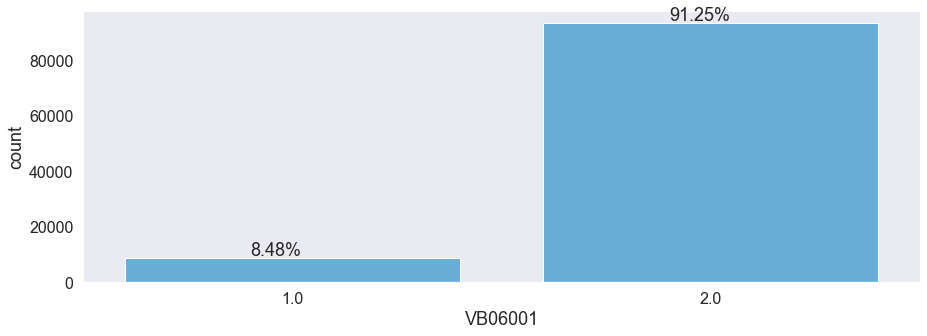

In [20]:
plt.figure(figsize=(15,5))

ax = sns.countplot('VB06001',data=aluno_escola,color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(aluno_escola['VB06001'])), (p.get_x()+ 0.3, p.get_height()+1000))

Podemos ver que é um caso de dados desbalanceados. Além disso, de acordo com o dicionário de dados, o valor "2" representa a ausência de consumo de drogas, enquanto que o valor "1" representa o uso de drogas.

Vamos remover os poucos exemplos sem informação, uma vez que esse é nosso target e mapear os valores para 0 (classe majoritária) e 1 (classe de interesse).

In [21]:
aluno_escola.dropna(axis='index', subset=['VB06001'], inplace=True)
map_target_values = {2.0: "0", 1.0: "1"}
aluno_escola['VB06001'] = aluno_escola.replace(map_target_values)['VB06001'] # não foi utilizado "inplace" pois o pandas altera os tipos de dados
aluno_escola['VB06001'] = aluno_escola['VB06001'].astype(int)
aluno_escola.shape

(101800, 293)

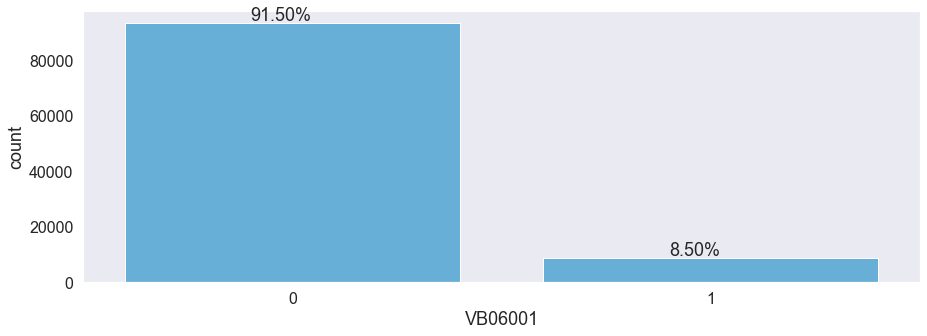

In [22]:
plt.figure(figsize=(15,5))

ax = sns.countplot('VB06001',data=aluno_escola,color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(aluno_escola['VB06001'])), (p.get_x()+ 0.3, p.get_height()+1000))

In [23]:
gc.collect()

2048

---

# Análise de Meta Dados

Os dados criados aqui fornecem uma forma de visualizar e selecionar as features a serem usadas mais a frente.

In [24]:
interval_features = ['TEMPODESLOC', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOTOTAL', 'TEMPOEST']
meta_data = utils.get_meta(aluno_escola, interval_features=interval_features)
meta_data

,role,level,keep,dtype
varname,,,,
ANOPESQ,input,categorical,True,int64
PAIS,input,categorical,True,int64
REGEOGR,input,categorical,True,int64
UFCENSO,input,categorical,True,int64
MUNICIPIO_CAP,input,categorical,True,int64
TIPO_MUNIC,input,categorical,True,int64
VB00004,input,categorical,True,int64
VB01001,input,categorical,True,int64
VB01002,input,categorical,True,float64


In [25]:
meta_counts = meta_data.groupby(['role', 'level']).agg({'dtype': lambda x: x.count()}).reset_index()
meta_counts

,role,level,dtype
0,id,nominal,1
1,input,categorical,286
2,input,interval,5
3,target,binary,1


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Variable Type'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

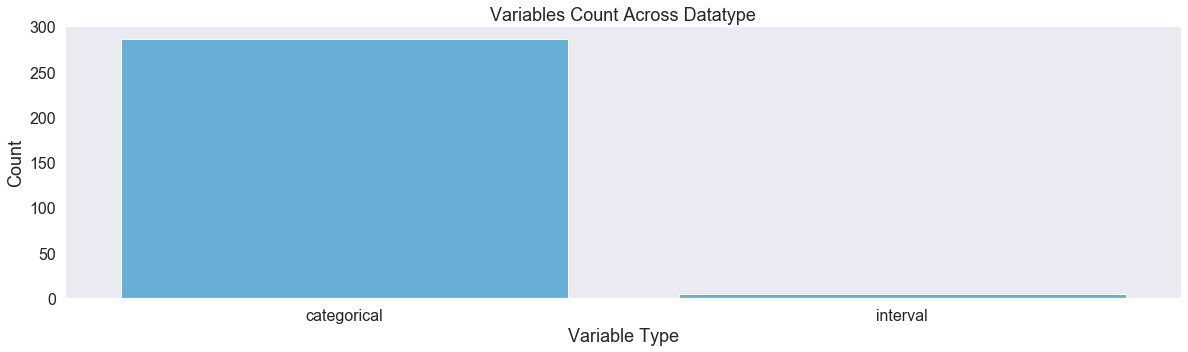

In [26]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],x="level",y="dtype",ax=ax,color=default_color)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [27]:
#Nomes de colunas para cada tipo de dados
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_interval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index
col_categorical = meta_data[(meta_data.level == 'categorical') & (meta_data.keep)].index

#Nomes de todas as colunas, removendo as com keep=False (por exemplo o ID dos alunos)
#Utilizado para propósitos de filtragem mais adiante
all_col = []
for col in col_ordinal:
    all_col.append(col)
for col in col_nominal:
    all_col.append(col)
for col in col_interval:
    all_col.append(col)
for col in col_binary:
    all_col.append(col)
for col in col_categorical:
    all_col.append(col)
all_col.append('VB06001')

In [28]:
gc.collect()

0

# Valores faltantes: NaNs

In [29]:
missingValueColumns = aluno_escola.columns[aluno_escola.isnull().any()].tolist()
df_null = aluno_escola[missingValueColumns]
len(missingValueColumns)

238

238 features possuem valores NaN. Gerando visualizações da quantidade de valores faltantes, a cada 80 features:

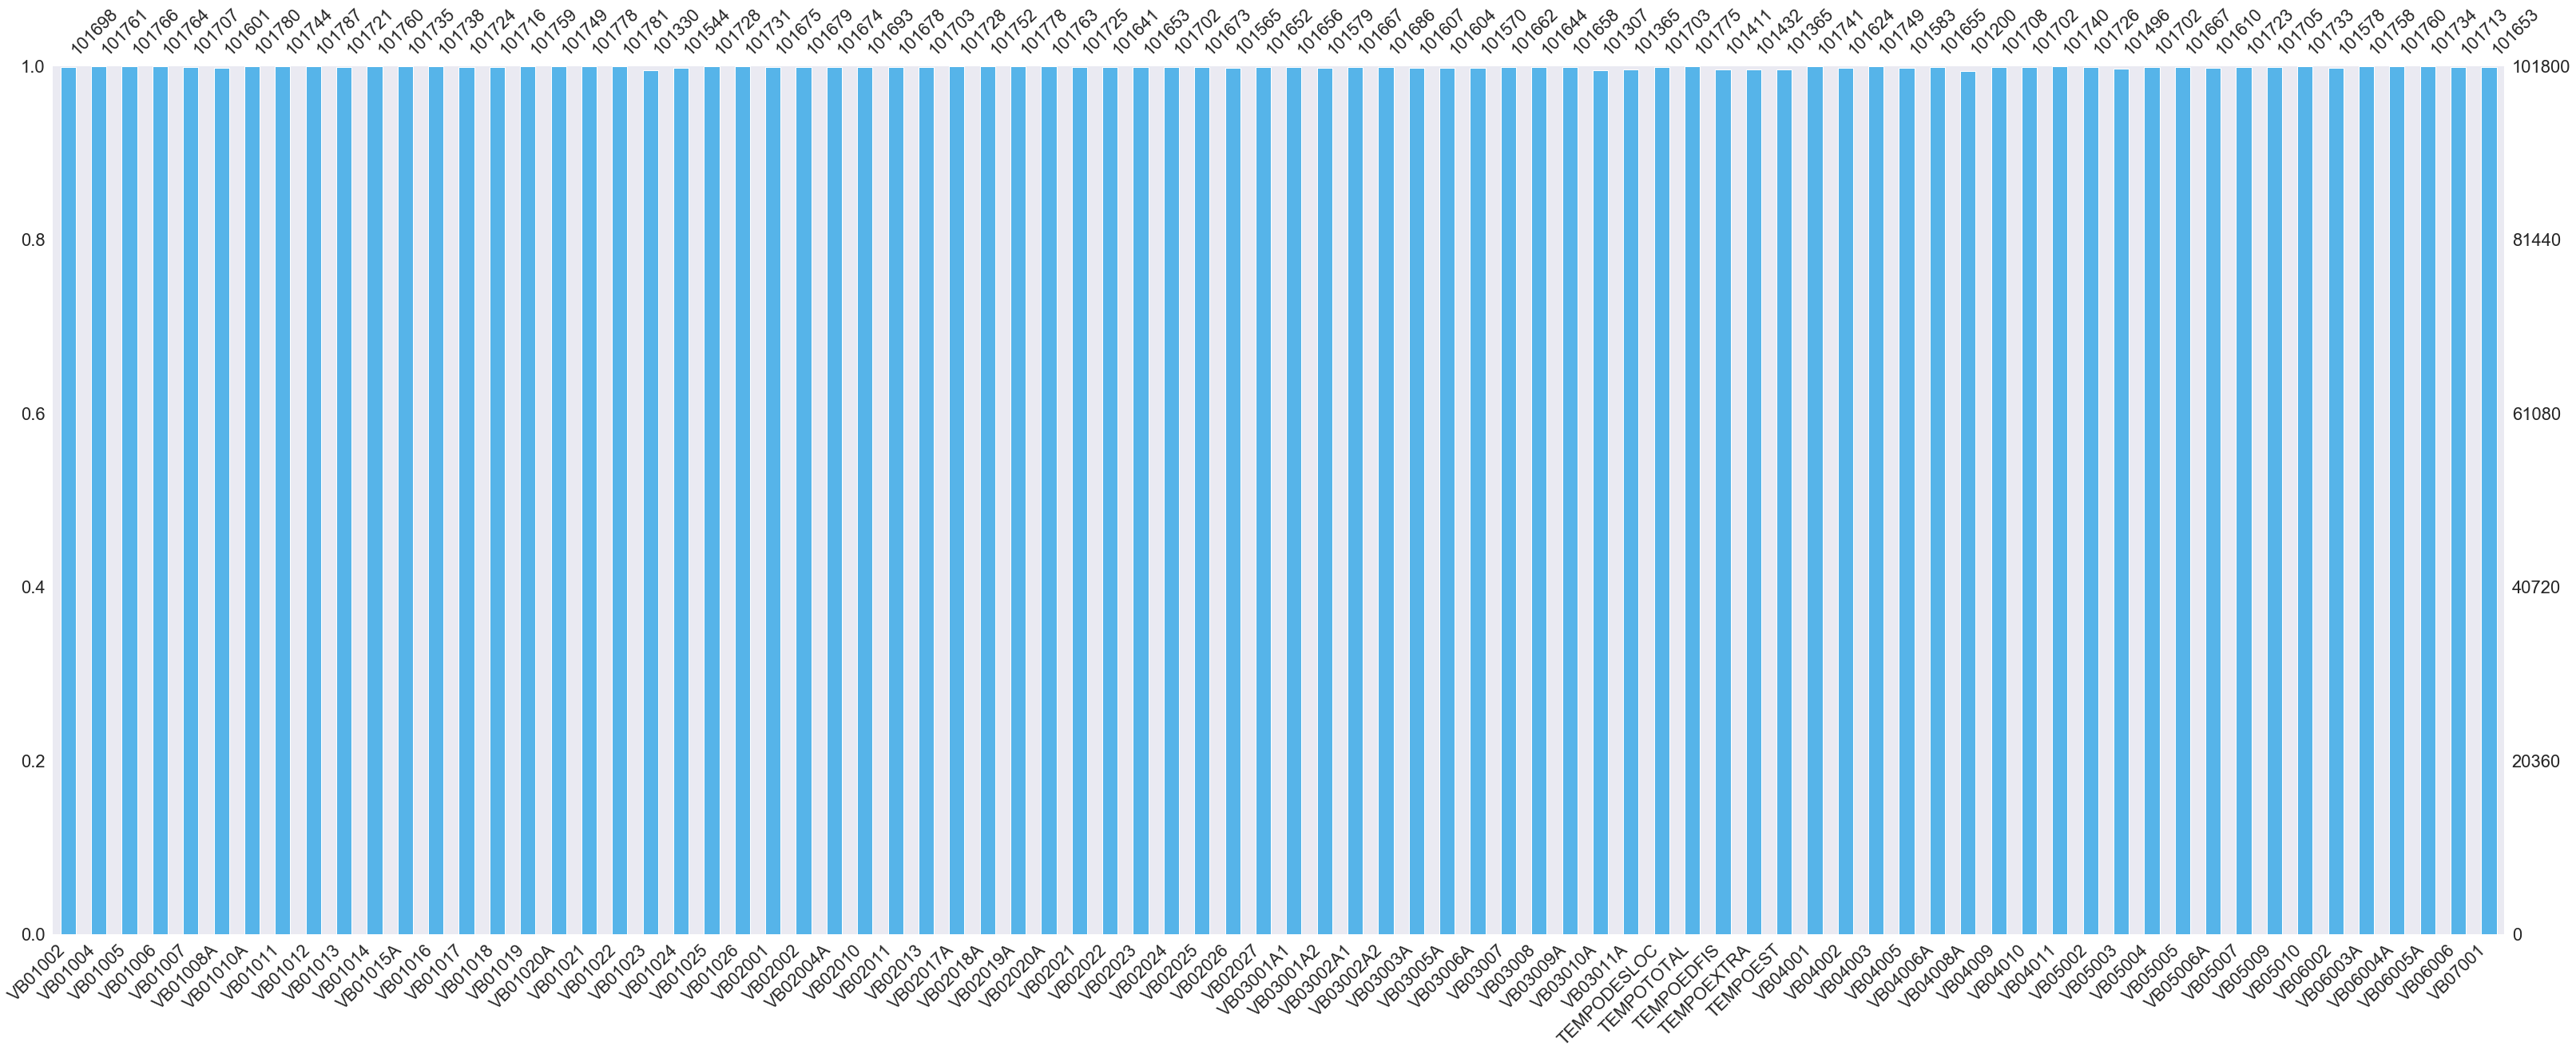

In [30]:
msno.bar(df_null.iloc[:, :80],figsize=(55,20),color=default_color,fontsize=22,labels=True)

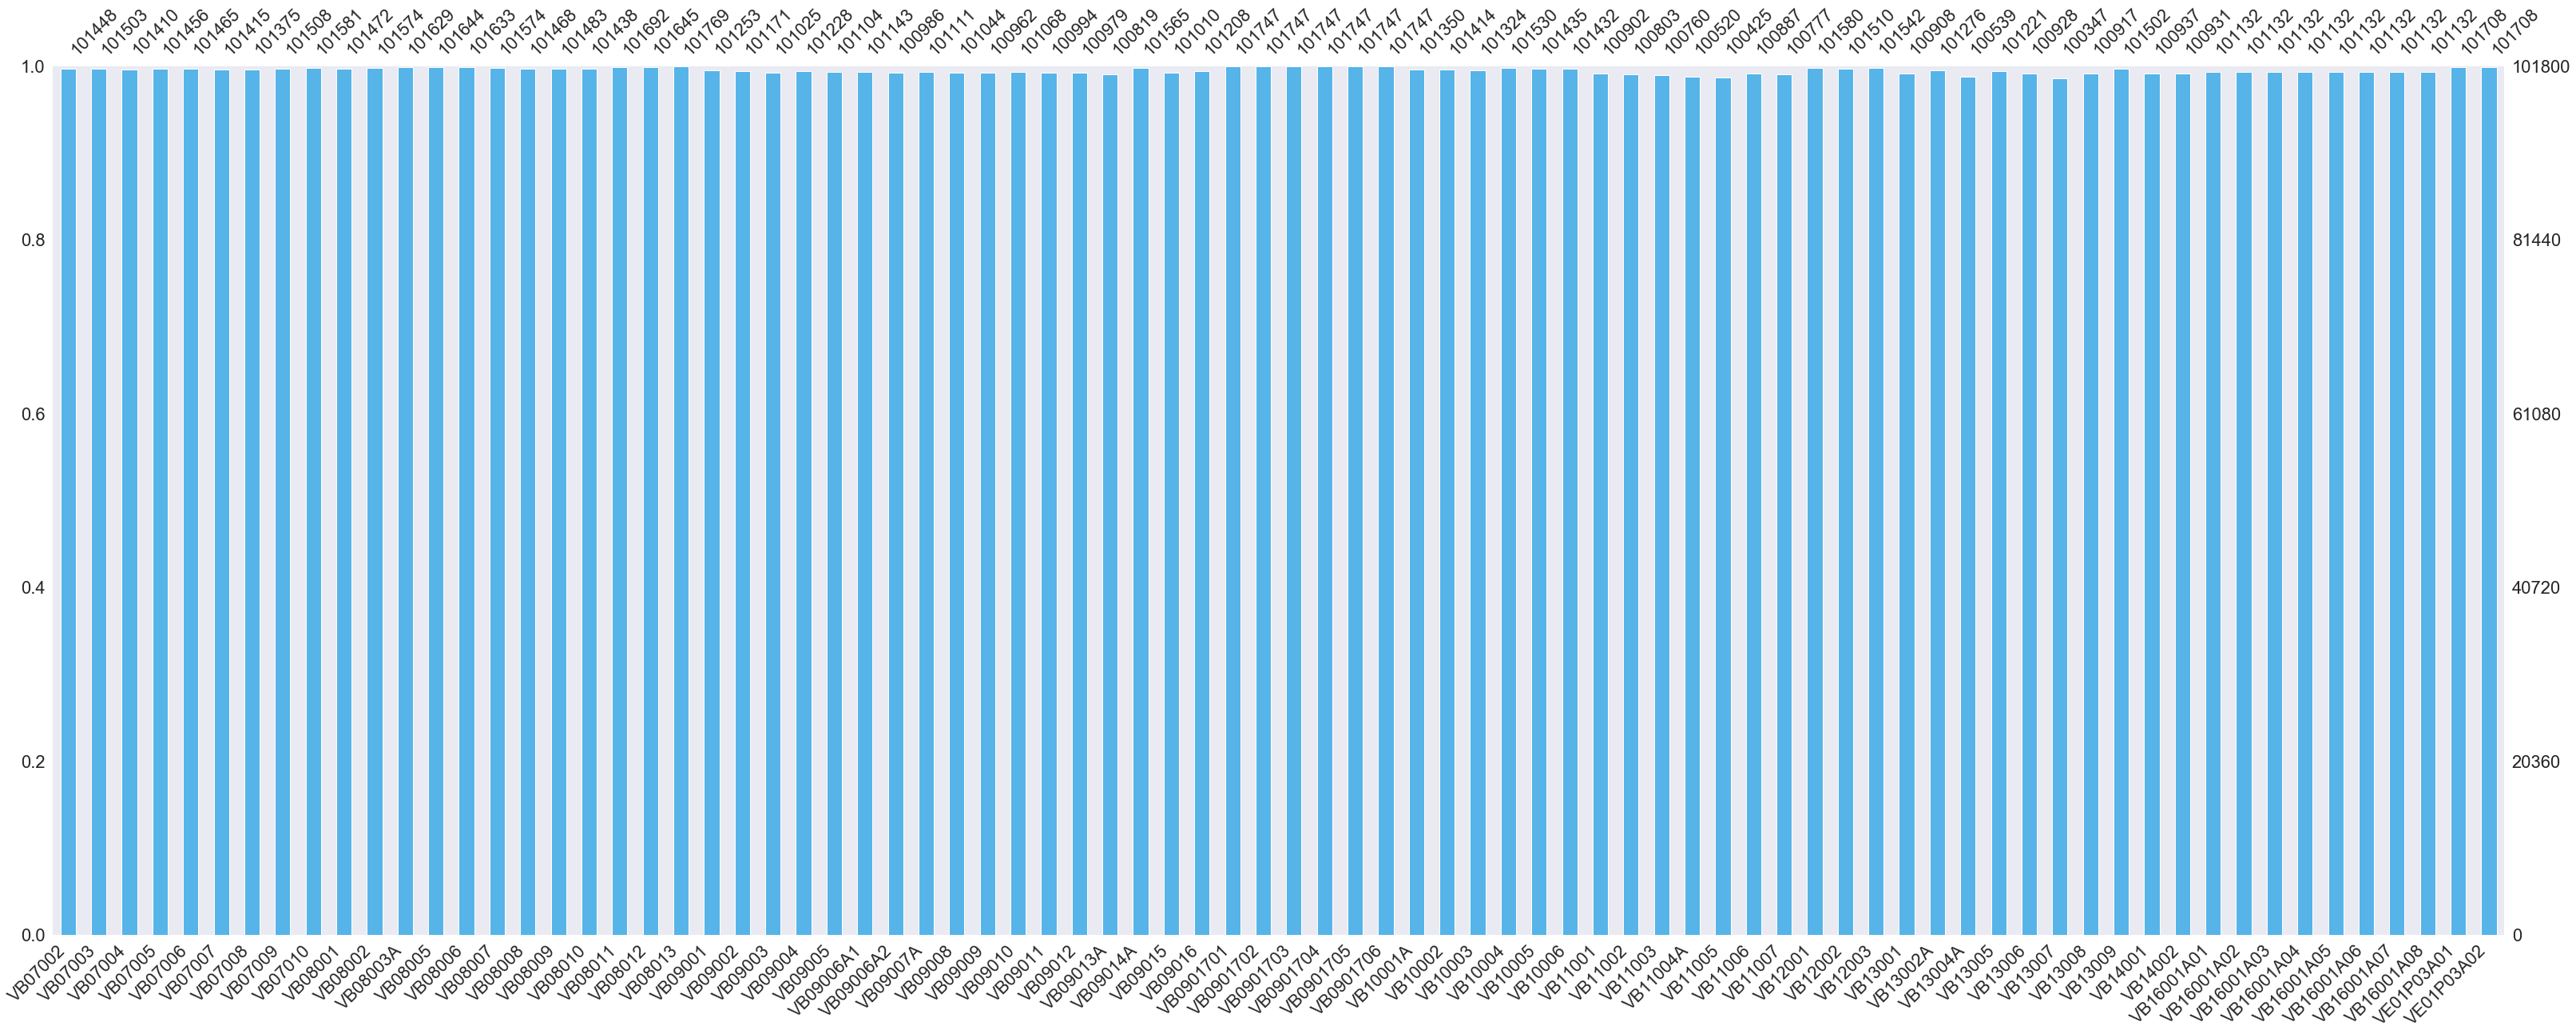

In [31]:
msno.bar(df_null.iloc[:, 80:160],figsize=(55,20),color=default_color,fontsize=22,labels=True)

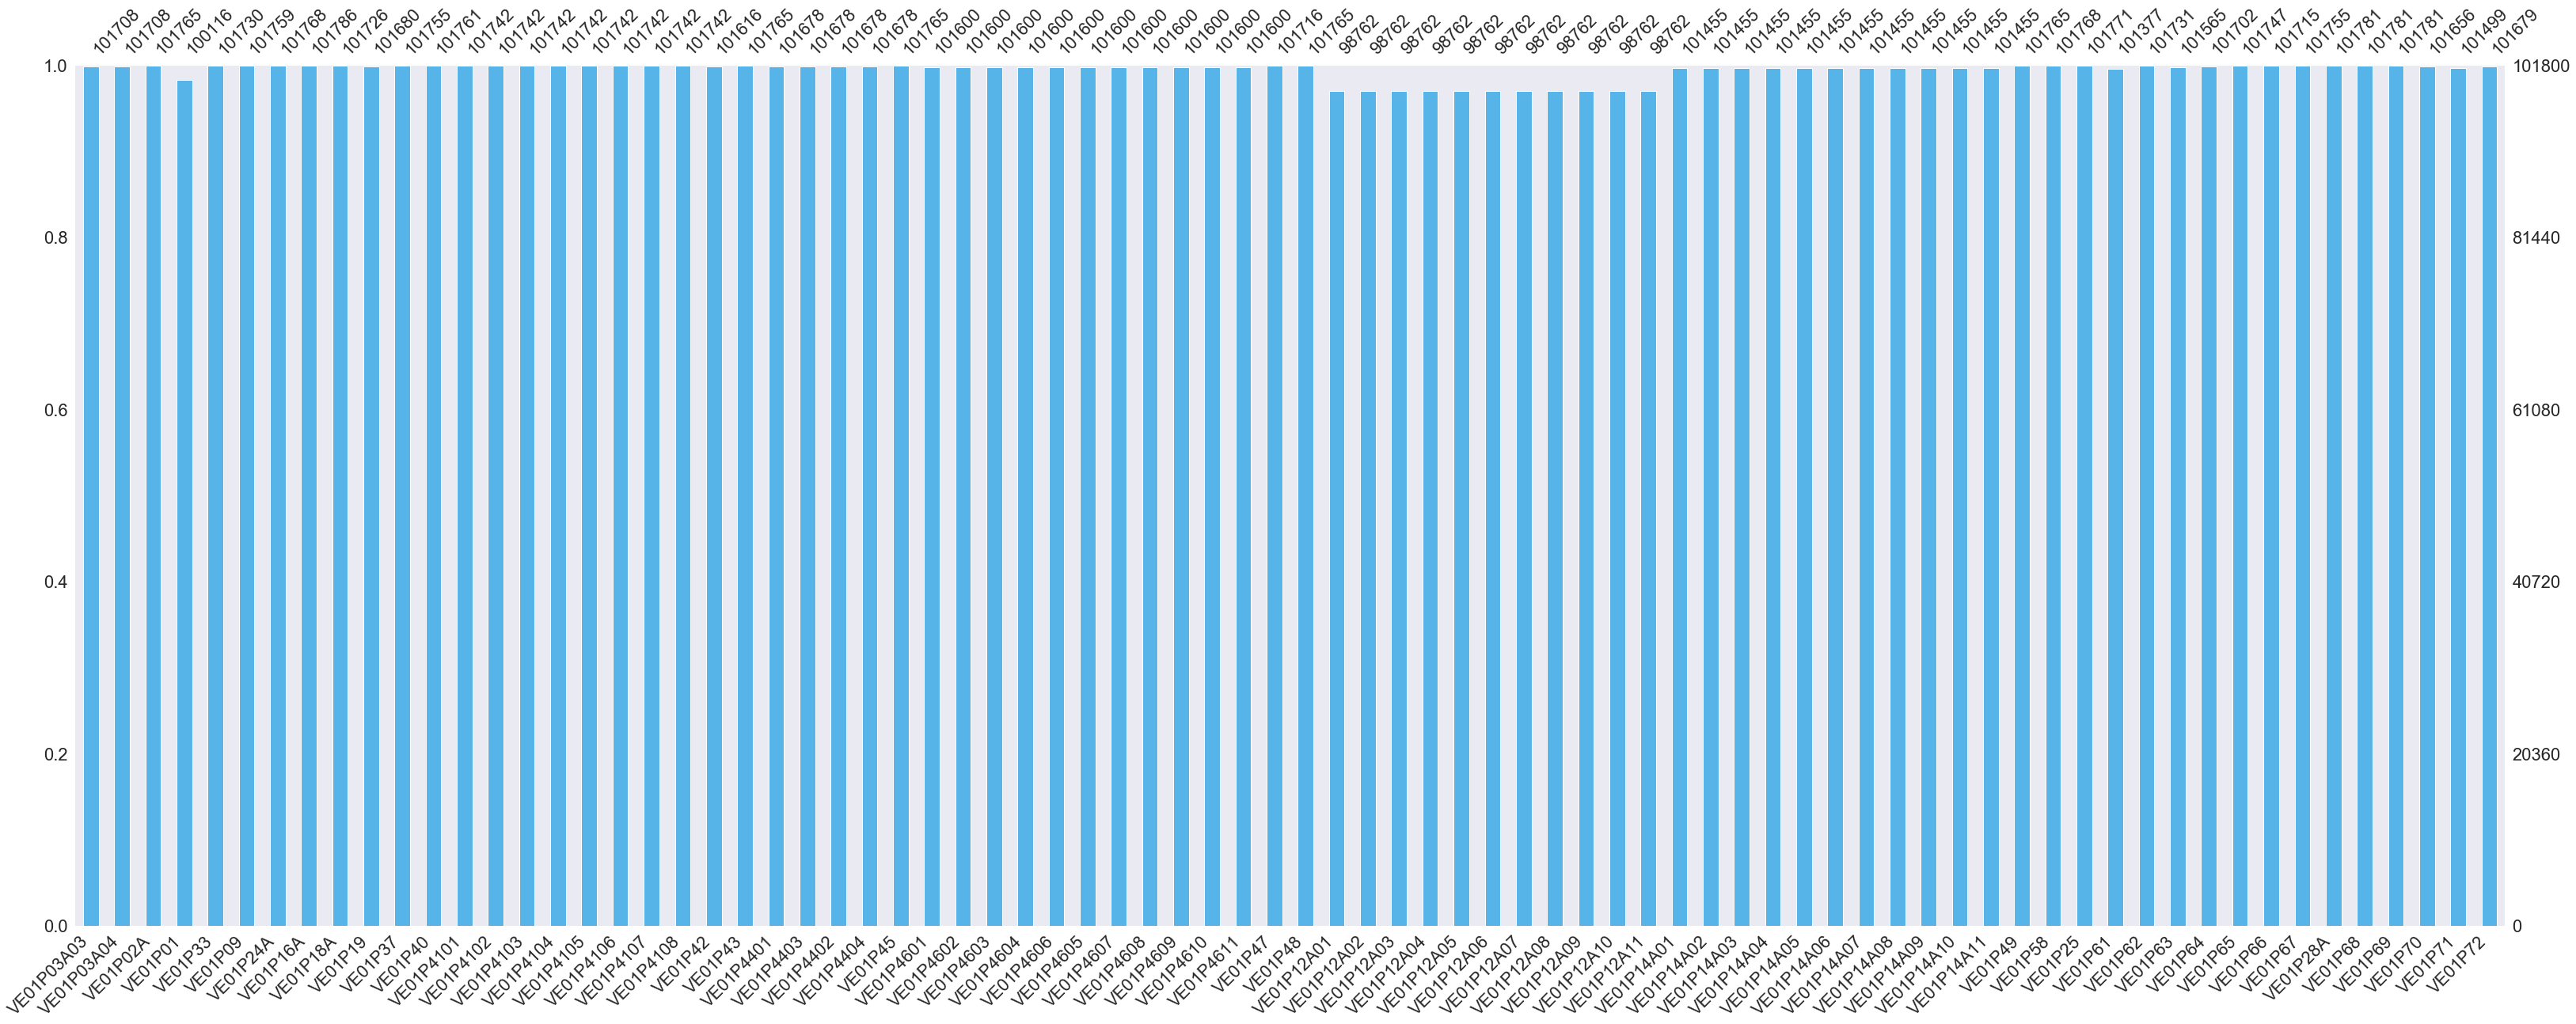

In [32]:
msno.bar(df_null.iloc[:, 160:240],figsize=(55,20),color=default_color,fontsize=22,labels=True)

In [33]:
gc.collect()

97

Podemos ver que a quantidade de NaNs é pequena. Isso pode indicar que será possível remover esses exemplos durante a Engenharia de Features mais a frente.

# Remoção de features

Para utilização dos modelos preditivos, temos antes que remover as features que dependem da resposta à pergunta target. As features são as seguintes:

* **VB06002** - Que idade você tinha quando usou droga como maconha, cocaína, crack, cola, loló, lança-perfume, ecstasy, oxy ou outra, pela primeira vez?

* **VB06003A** - NOS ÚLTIMOS 30 DIAS, quantos dias você usou droga como maconha, cocaína, crack, cola, loló, lança-perfume, ecstasy, oxy, etc?

* **VB06004A** - NOS ÚLTIMOS 30 DIAS, quantos dias você usou maconha? 

* **VB06005A** - NOS ÚLTIMOS 30 DIAS, quantos dias você usou crack?

Isso se deve ao fato de que essas features correspondem ao perfil do aluno **após o acontecimento respondido pelo target**. Caso essa informação seja mantida nas features utilizadas, elas apresentarão um alto grau de correlação com o target, porém não possuem **poder preditivo**, uma vez que o fato estudado pelo target já aconteceu (aluno já experimentou drogas).

Importante notar que os dados já estão codificados, portanto não precisamos de técnicas como one hot encoding ou label encoding.

Podemos remover também features que não variam (exemplo feature "PAIS"), features utilizadas para amostragem e expansão:

* **ANOPESQ**

* **PAIS**

* **VB00004**

* **PESO**

* **escola**

* **turma**

* **ESTRATOGEOREG**

* **ESTRATO_EXP**

# Testando feature importances

### Feature importances com XGBoost

Com relação aos valores NaNs, o XGBClassifier possui tratativa para dados com NaNs. Ele gera direções "padrão" para exemplos de dados, mesmo que não explícito em cada split das árvores de decisão, conforme artigo "**XGBoost: A Scalable Tree Boosting System**"

In [34]:
non_pred_features = ['VB06002', 'VB06003A', 'VB06004A', 'VB06005A', 'ANOPESQ', 'PAIS', 'VB00004', 'PESO', 'escola', 'turma', 'ESTRATOGEOREG', 'ESTRATO_EXP']
for feat in non_pred_features:
    all_col.remove(feat)

In [35]:
def return_data_baseline_tree(data, all_columns):
    df = data[all_columns].copy()
    X = df.drop('VB06001',axis=1)
    y = df['VB06001']
    return X, y

In [36]:
X, y = return_data_baseline_tree(aluno_escola, all_col)

In [37]:
# Parâmetros iniciais razoáveis para o XGBClassifier
xgb_params = {}
xgb_params['learning_rate'] = 0.1
xgb_params['n_estimators'] = 500
xgb_params['objective'] = 'rank:pairwise'
xgb_params['n_jobs'] = 4
xgb_params['max_depth'] = 5
xgb_params['min_child_weight'] = 1
xgb_params['gamma'] = 0
xgb_params['subsample'] = 0.8
xgb_params['colsample_bytree'] = 0.8
xgb_params['scale_pos_weight'] = 1
xgb_params['random_state'] = 10
XGB_model = XGBClassifier(**xgb_params)

In [42]:
#Recuperando as feature_importances_ (alternativa para não rodar o treino abaixo)
file_Name = output_path + "feature_importance_xgb"
fileObject = open(file_Name,'rb')
feature_importance_xgb = pickle.load(fileObject)
features = X.columns.values

In [48]:
XGB_model.fit(X, y)
print("----- Training Done -----")

----- Training Done -----


In [49]:
#Todas as feature importances (279 features restantes)
try:
    feature_importance_xgb = utils.get_feature_importance_df(XGB_model.feature_importances_, features, top_n=279)
except:
    feature_importance_xgb = utils.get_feature_importance_df(feature_importance_xgb, features, top_n=279)

[Text(0, 0.5, 'Variable name'),
 Text(0.5, 0, 'Importance'),
 Text(0.5, 1.0, 'Variable importances')]

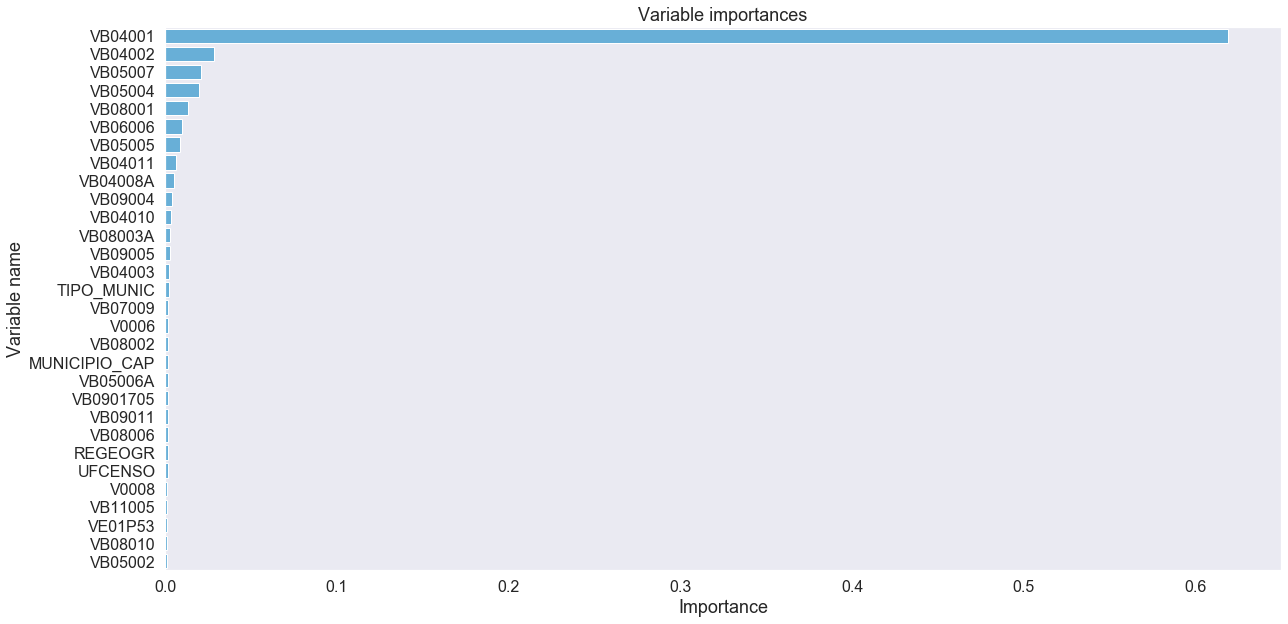

In [51]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance_xgb[:30],x="importance",y="feature",ax=ax,color=default_color)
ax.set(xlabel='Importance', ylabel='Variable name',title="Variable importances")

In [52]:
file_Name = output_path + "feature_importance_xgb"
fileObject = open(file_Name,'wb') 
pickle.dump(feature_importance_xgb,fileObject)
fileObject.close()

In [54]:
gc.collect()

0

---

# Modelo Baseline

O modelo XGBClassifier utilizado acima será considerado como modelo Baseline. O ideal seria tentarmos outros tipos de modelos para comparação, porém dado o tempo para entrega será utilizado apenas esse modelo.

Com relação à optimização do modelo, será considerada a métrica AUCROC (área abaixo da curva ROC). A otimização dessa métrica possui como característica a "separação" das distribuições de probabilidades preditas às classes (0 e 1). Quanto maior o grau de separação das probabilidades (maior probabilidade para as classes 1), maior é o valor da métrica. A AUCROC é muito utilizada em problemas com dados desbalanceados, assim como é o problema proposto. Para isso, o objetivo utilizado será "rank:pairwise". Esse objetivo considera uma função custo em pares de dados (exemplos), encorpando assim a otimização da métrica AUCROC.

Com um modelo com a métrica AUCROC satisfatória, é possível escolhermos o valor de threshold que melhor se adequa ao problema, no caso: preferimos prever todos os alunos com altas chances de uso de drogas, mesmo prevendo também alguns que não tenham tanto risco.

A função cross_val_model_shuffle gera estimativas para o score fora da amostra (*out of sample*). Foi utilizado o parâmetro "shuffle" para não cairmos em uma situação aonde as distribuições de treino e de validação possuam distribuições diferentes, devido ao processo de amostragem e ordem do conjunto de dados.

#### XGBoost Model

In [55]:
# Parâmetros razoáveis para o XGBClassifier
xgb_params = {}
xgb_params['learning_rate'] = 0.1
xgb_params['n_estimators'] = 500
xgb_params['objective'] = 'rank:pairwise'
xgb_params['n_jobs'] = 4
xgb_params['max_depth'] = 5
xgb_params['min_child_weight'] = 1
xgb_params['gamma'] = 0
xgb_params['subsample'] = 0.8
xgb_params['colsample_bytree'] = 0.8
xgb_params['scale_pos_weight'] = 1
xgb_params['random_state'] = 10

In [56]:
XGB_model = XGBClassifier(**xgb_params)

In [57]:
X, y = return_data_baseline_tree(aluno_escola, all_col)

In [58]:
def cross_val_model_shuffle(X, y, model, n_splits=3, use_random_state=True):
    X = np.array(X)
    y = np.array(y)
    if use_random_state:
        sfkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)
    else:
        sfkf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    cross_score = cross_val_score(model, X, y, cv=sfkf, scoring='roc_auc')
    return cross_score

In [59]:
cross_score = cross_val_model_shuffle(X, y, XGB_model, n_splits=10, use_random_state=True)

In [60]:
print("Cross_scores: ", cross_score)
print("Mean cross_score: %.5f" % cross_score.mean())

Cross_scores:  [0.94341516 0.94363123 0.94815534 0.94495047 0.94049832 0.94365171
 0.94245123 0.94709462 0.9428684  0.9473451 ]
Mean cross_score: 0.94441


In [61]:
gc.collect()

197

# Análise Exploratória dos Dados

De forma a focar em responder a questão abaixo, vamos analisar as features com maior importância, identificando os grupos com maior incidência de casos:

* Como identificar os alunos que farão uso de drogas ilícitas, pensando em grupos alvo para ações de prevenção?

In [62]:
#Primeiras 10 features para análise
eda_features = feature_importance_xgb[:10].feature.values

#### Primeira Feature: VB06006 - Quantos amigos seus usam drogas?

In [63]:
feature = eda_features[0]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


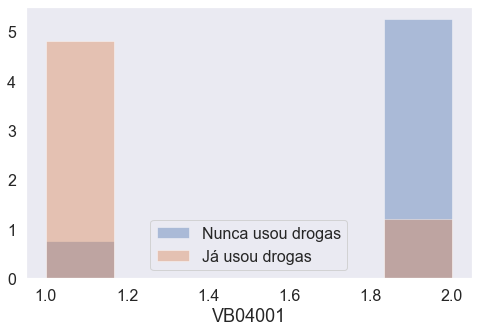

In [64]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(8,5))
sns.distplot(target_0, bins=6, kde=False, norm_hist=True)
sns.distplot(target_1, bins=6, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

O gráfico acima mostra que os amigos exercem alta influência com relação ao uso de drogas. Os valores 2, 3, 4 e 5 indicam que os amigos usam drogas.

#### Segunda Feature: TEMPOTOTAL - tempo de atividade física, considerando ir e voltar da escola, aulas de educação física e outras atividades extraescolares. Em minutos.

In [65]:
feature = eda_features[1]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


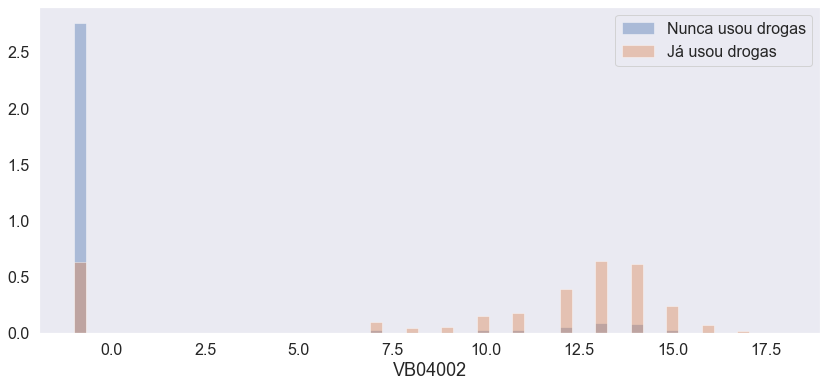

In [66]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(14,6))
sns.distplot(target_0, bins=60, kde=False, norm_hist=True)
sns.distplot(target_1, bins=60, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

O gráfico acima sugere que os alunos que já usaram drogas gastam mais tempo nas atividades físicas consideradas.

#### Terceira Feature: UFCENSO - Unidade da Federação

In [67]:
feature = eda_features[2]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


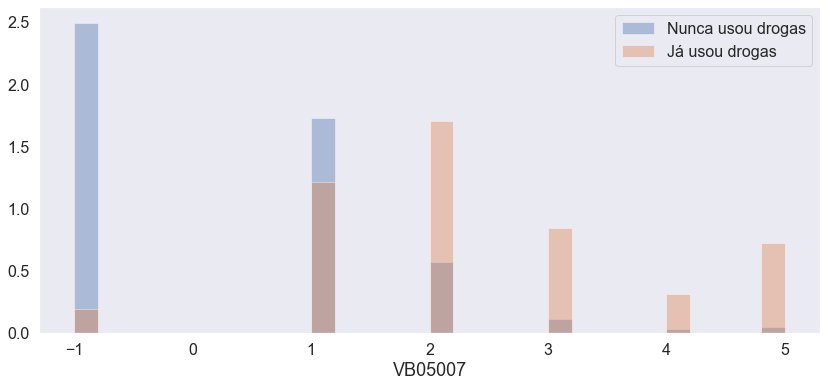

In [68]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(14,6))
sns.distplot(target_0, bins=30, kde=False, norm_hist=True)
sns.distplot(target_1, bins=30, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

In [69]:
gc.collect()

35

#### Quarta Feature: VB04002 - Que idade você tinha quando experimentou fumar cigarro pela primeira vez?

In [70]:
feature = eda_features[3]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


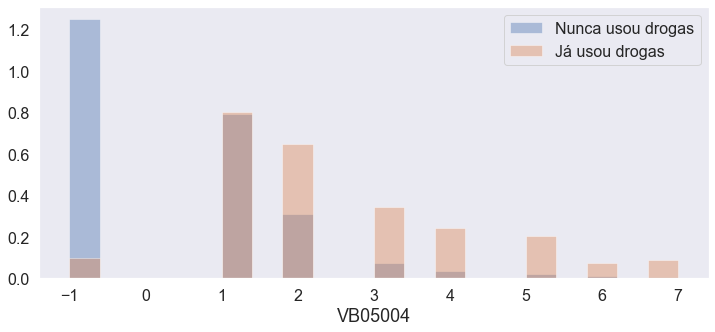

In [71]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(12,5))
sns.distplot(target_0, bins=20, kde=False, norm_hist=True)
sns.distplot(target_1, bins=20, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

Podemos verificar que a idade do início de uso de cigarro está relacionado ao uso de drogas ilícitas, e a faixa de idade com maior risco é entre 10-16 anos.

A idade é uma informação que vem após a informação da feature VB04001 (se o aluno já usou cigarro). Como podemos ver abaixo, também é uma feature com diferença nas distribuições entre classe 0 e classe 1.

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


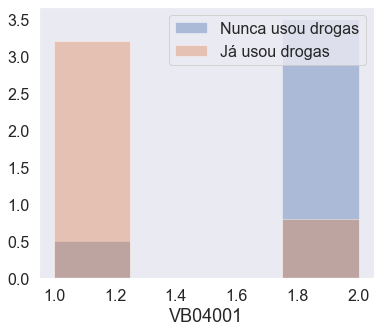

In [72]:
target_1 = aluno_escola['VB04001'][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola['VB04001'][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(6,5))
sns.distplot(target_0, bins=4, kde=False, norm_hist=True)
sns.distplot(target_1, bins=4, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

In [73]:
gc.collect()

15

Portanto podemos concluir que o uso de cigarro é um indicador de risco de uso de drogas ilícitas, com maior grau de risco na faixa de idade entre 10 e 16 anos.

#### Quinta Feature: VB05010 - Quantos amigos seus consomem bebida alcoólica?

In [74]:
feature = eda_features[4]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


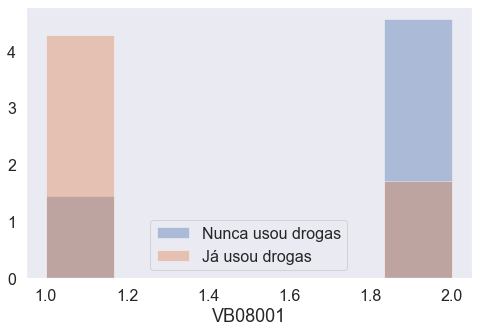

In [75]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(8,5))
sns.distplot(target_0, bins=6, kde=False, norm_hist=True)
sns.distplot(target_1, bins=6, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

In [76]:
gc.collect()

15

Podemos ver que um alto número de amigos que consomem bebida alcoólica também indica alto risco de uso de drogas ilícitas.

#### Sexta Feature: MUNICIPIO_CAP

In [77]:
feature = eda_features[5]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


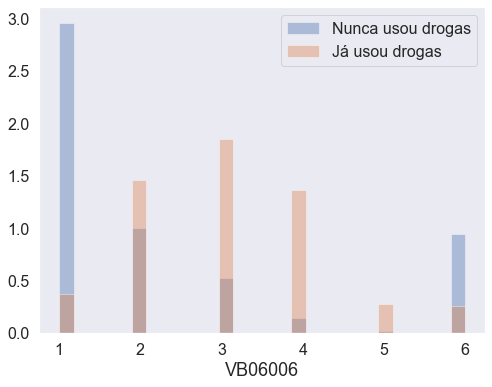

In [78]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(8,6))
sns.distplot(target_0, bins=28, kde=False, norm_hist=True)
sns.distplot(target_1, bins=28, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

In [79]:
gc.collect()

15

#### Sétima Feature: VB05007 - Na sua vida, quantas vezes você bebeu tanto que ficou realmente bêbado(a)?

In [80]:
feature = eda_features[6]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


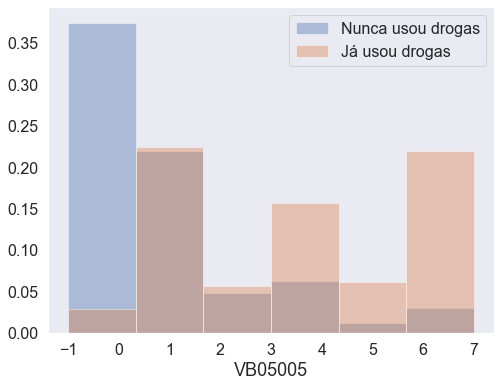

In [81]:
target_1 = aluno_escola[feature][aluno_escola['VB06001'] == 1]
target_0 = aluno_escola[feature][aluno_escola['VB06001'] == 0]
plt.figure(figsize=(8,6))
sns.distplot(target_0, bins=6, kde=False, norm_hist=True)
sns.distplot(target_1, bins=6, kde=False, norm_hist=True)
plt.legend(["Nunca usou drogas", "Já usou drogas"])

Podemos ver que o exagero no consumo de alcool indica alto risco de uso de drogas ilícitas.

# Engenharia de Features

## Testando o impacto de remover features com baixa importância:

A seleção de features é um aspecto que ajuda a análise pois visa minimizar os efeitos da "Curse of Dimensionality". Esse problema surge do fato de a cada feature que é adicionada, é criado um espaço "vazio" no espaço das features, o que pode gerar problemas de generalização do modelo.

Abaixo temos o teste de redução para 180 features. Devido ao tempo foi testado apenas esse número e gerado a estimativa do score fora de amostra (out of sample) via validação cruzada.

In [82]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.1
xgb_params['n_estimators'] = 500
xgb_params['objective'] = 'rank:pairwise'
xgb_params['n_jobs'] = 4
xgb_params['max_depth'] = 5
xgb_params['min_child_weight'] = 1
xgb_params['gamma'] = 0
xgb_params['subsample'] = 0.8
xgb_params['colsample_bytree'] = 0.8
xgb_params['scale_pos_weight'] = 1
xgb_params['random_state'] = 10

In [83]:
XGB_model = XGBClassifier(**xgb_params)

In [84]:
X, y = return_data_baseline_tree(aluno_escola, all_col)

In [85]:
cross_score = cross_val_model_shuffle(X[feature_importance_xgb.feature[:180].values], y, XGB_model, n_splits=10, use_random_state=True)

In [352]:
print("Cross_scores: ", cross_score)
print("Mean cross_score: %.5f" % cross_score.mean())

Cross_scores:  [0.94010517 0.94803608 0.94825811 0.94902793 0.94316287 0.94552602
 0.94455757 0.94545324 0.94464545 0.93998828]
Mean cross_score: 0.94488


In [86]:
print("Cross_scores: ", cross_score)
print("Mean cross_score: %.5f" % cross_score.mean())

Cross_scores:  [0.94467626 0.94431639 0.94791894 0.9449139  0.94196802 0.94363138
 0.9421583  0.94851184 0.94427011 0.94903775]
Mean cross_score: 0.94514


In [87]:
gc.collect()

285

# Conclusão

Com relação aos grupos alvo para ações de prevenção do uso de drogas, podemos identificar as seguintes características de risco:

- Uso de cigarro
- Uso de bebida alcoólica
- Exagero no consumo de bebida alcoólica
- Alta prática das atividades físicas consideradas

A análise deve ser continuada para identificação de outros padrões.